In [2]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import pandas as pd
import platform


# 한글 폰트 설정
if platform.system() == 'Darwin':  
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  
    rc('font', family='Malgun Gothic')
else:  
    rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

In [3]:
quarterly_data = pd.read_csv('data/quarterly_combined.csv', index_col=0, parse_dates=True).astype(float)
quarterly_data

,korea_cd_quarterly,treasury_3month_quarterly,usd_krw_quarterly
2000-03-31,7.01,5.88,1106.0
2000-06-30,7.18,5.88,1115.0
2000-09-30,7.05,6.23,1115.0
2000-12-31,6.88,5.89,1264.5
2001-03-31,5.70,4.30,1327.5
...,...,...,...
2023-09-30,3.83,5.55,1349.3
2023-12-31,3.83,5.40,1288.0
2024-03-31,3.64,5.46,1347.2
2024-06-30,3.60,5.48,1376.7


In [4]:
# 환율 변화율 (S_t+1 - S_t) / S_t
exchange_rate_change_quarterly = quarterly_data.usd_krw_quarterly.pct_change().iloc[1:]
# 국내 이자율 (i_t)
domestic_interest_rate_quarterly = quarterly_data.korea_cd_quarterly.iloc[1:]
# 미국 이자율 (i_t^*)
foreign_interest_rate_quarterly = quarterly_data.treasury_3month_quarterly.iloc[1:]

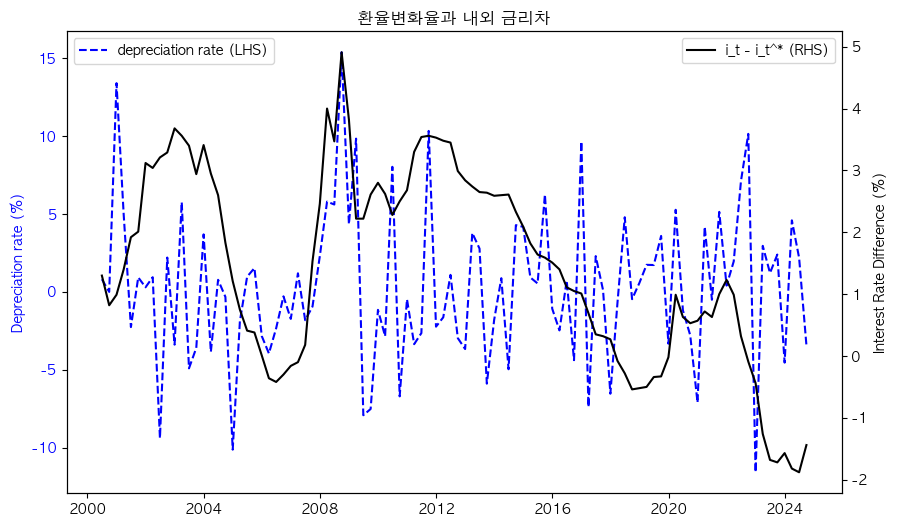

In [5]:
# 내외 금리차 계산
interest_rate_diff_quarterly = domestic_interest_rate_quarterly - foreign_interest_rate_quarterly

# 그림을 그릴 날짜 범위 선택
dates = exchange_rate_change_quarterly.index

# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(10, 6))

# 좌측 y축: 환율 변화율
ax1.plot(dates, exchange_rate_change_quarterly * 100, 'b--', label='depreciation rate (LHS)')
ax1.set_ylabel('Depreciation rate (%)', color='b')  # 좌측 y축 레이블 설정
ax1.tick_params(axis='y', labelcolor='b')  # 좌측 y축 눈금 색상 설정3 

# 우측 y축: 내외 금리차
ax2 = ax1.twinx()  # 두 번째 y축 생성
ax2.plot(dates, interest_rate_diff_quarterly, 'k-', label='i_t - i_t^* (RHS)')
ax2.set_ylabel('Interest Rate Difference (%)', color='k')  # 우측 y축 레이블 설정
ax2.tick_params(axis='y', labelcolor='k')  # 우측 y축 눈금 색상 설정

# 그래프 제목 및 범례 설정
plt.title('환율변화율과 내외 금리차')  # 그래프 제목 설정
ax1.legend(loc='upper left')  # 좌측 y축 범례 위치 설정
ax2.legend(loc='upper right')  # 우측 y축 범례 위치 설정

# 그래프 출력
plt.show()  # 그래프 표시

In [6]:
daily_data = pd.read_csv('data/daily_combined.csv', index_col=0, parse_dates=True).astype(float)
daily_data

,korea_cd_daily,treasury_3month_daily,usd_krw_daily
2000-01-04,7.35,5.43,1122.5
2000-01-05,7.37,5.44,1135.0
2000-01-06,7.38,5.41,1146.6
2000-01-07,7.38,5.38,1138.0
2000-01-08,7.38,5.38,1138.0
...,...,...,...
2024-09-09,3.51,5.11,1339.8
2024-09-10,3.51,5.06,1343.7
2024-09-11,3.51,5.10,1339.0
2024-09-12,3.51,5.06,1338.7


In [7]:
exchange_rate_change_daily = daily_data.usd_krw_daily.pct_change().iloc[1:]
domestic_interest_rate_daily = daily_data.korea_cd_daily.iloc[1:]
foreign_interest_rate_daily = daily_data.treasury_3month_daily.iloc[1:]

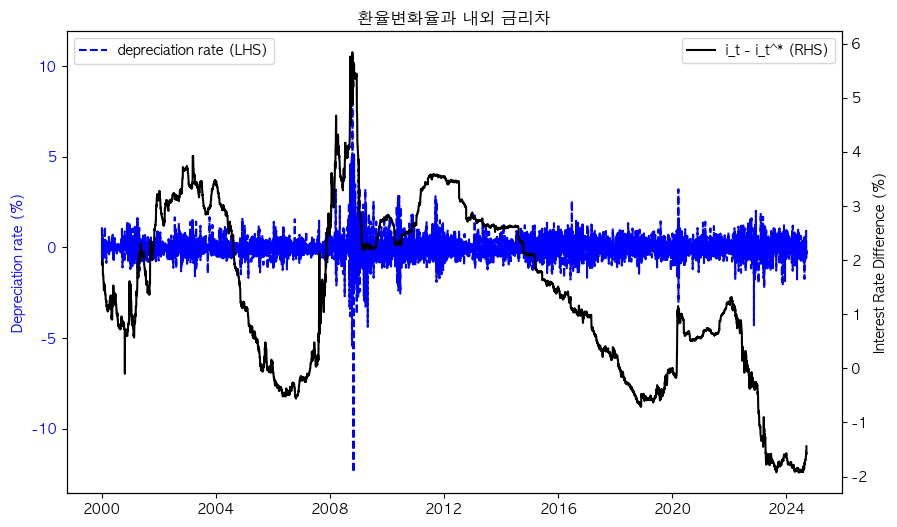

In [8]:
interest_rate_diff_daily = domestic_interest_rate_daily - foreign_interest_rate_daily
dates_daily = exchange_rate_change_daily.index
# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(10, 6))

# 좌측 y축: 환율 변화율

ax1.plot(dates_daily, exchange_rate_change_daily * 100, 'b--', label='depreciation rate (LHS)')
ax1.set_ylabel('Depreciation rate (%)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# 우측 y축: 내외 금리차
ax2 = ax1.twinx()
ax2.plot(dates_daily, interest_rate_diff_daily, 'k-', label='i_t - i_t^* (RHS)')
ax2.set_ylabel('Interest Rate Difference (%)', color='k')
ax2.tick_params(axis='y', labelcolor='k')

# 그래프 제목 및 범례 설정
plt.title('환율변화율과 내외 금리차')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 그래프 출력
plt.show()


In [47]:
import arviz as az
def run_bayesian_regression(exchange_rate_change, interest_rate_diff):
    T = len(exchange_rate_change)
    # 2. 선형 회귀 모형 설정
    with pm.Model() as model:
        # 사전 분포 설정
        alpha0 = 50
        beta0 = 1000 * alpha0
        sigma2 = pm.InverseGamma('sigma2', alpha=alpha0 / 2, beta=beta0 / 2)
        beta = pm.MvNormal('beta', mu=np.array([0, 1]), cov=25 * np.eye(2), shape=2)

        # 설명변수 X 구성
        X = np.column_stack([
            np.ones(T),  # 상수항 a1
            interest_rate_diff  # i_t - i_t^*
        ])

        # 종속변수 Y
        Y = exchange_rate_change

        # 우도 함수 설정 (선형 회귀)
        Y_obs = pm.Normal('Y_obs', mu=pm.math.dot(X, beta), sigma=pm.math.sqrt(sigma2), observed=Y)

        # 5000번 샘플링
        # cores는 병렬로 샘플링을 수행할 CPU 코어의 수를 의미하고, chains는 독립적으로 샘플링을 수행할 체인의 수를 의미합니다.
        # 사용 가능한 코어 수가 7개이므로 cores를 7로 설정합니다.
        # chains는 일반적으로 4로 설정하는 것이 좋습니다.
        trace = pm.sample(1000, cores=7, chains=6)


    # 1. 트레이스 플롯
    az.plot_trace(trace)
    plt.suptitle("Trace Plot")
    plt.tight_layout()
    plt.show()
    az.plot_posterior(trace)
    plt.suptitle("Posterior Distribution")
    plt.tight_layout()
    plt.show()
    az.plot_ess(trace)
    plt.title("Effective Sample Size")
    plt.tight_layout()
    plt.show()
    az.plot_forest(trace)
    plt.title("Forest Plot")
    plt.tight_layout()
    plt.show()
    az.plot_energy(trace)
    plt.title("Energy Plot")
    plt.tight_layout()
    plt.show()
    summary = az.summary(trace)
    print("Summary Statistics:")
    print(summary)

    return trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [sigma2, beta]


Output()

Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 23 seconds.


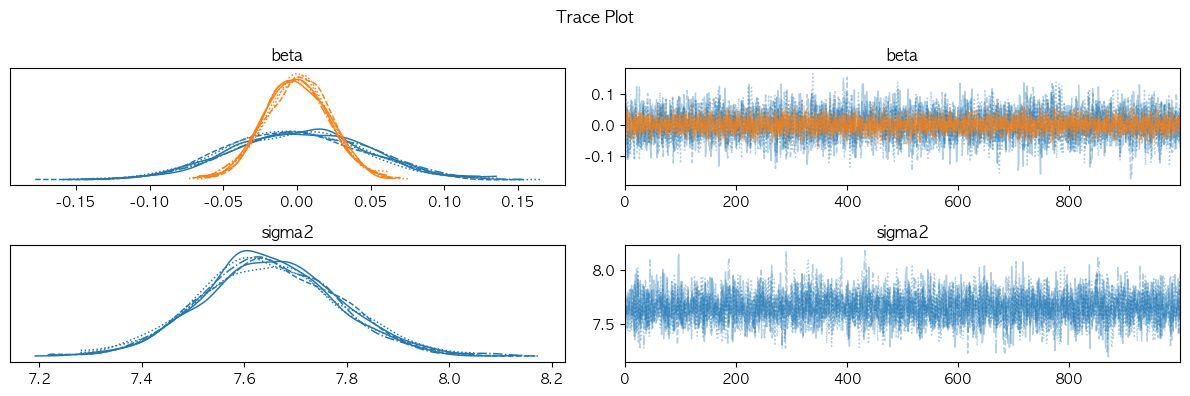

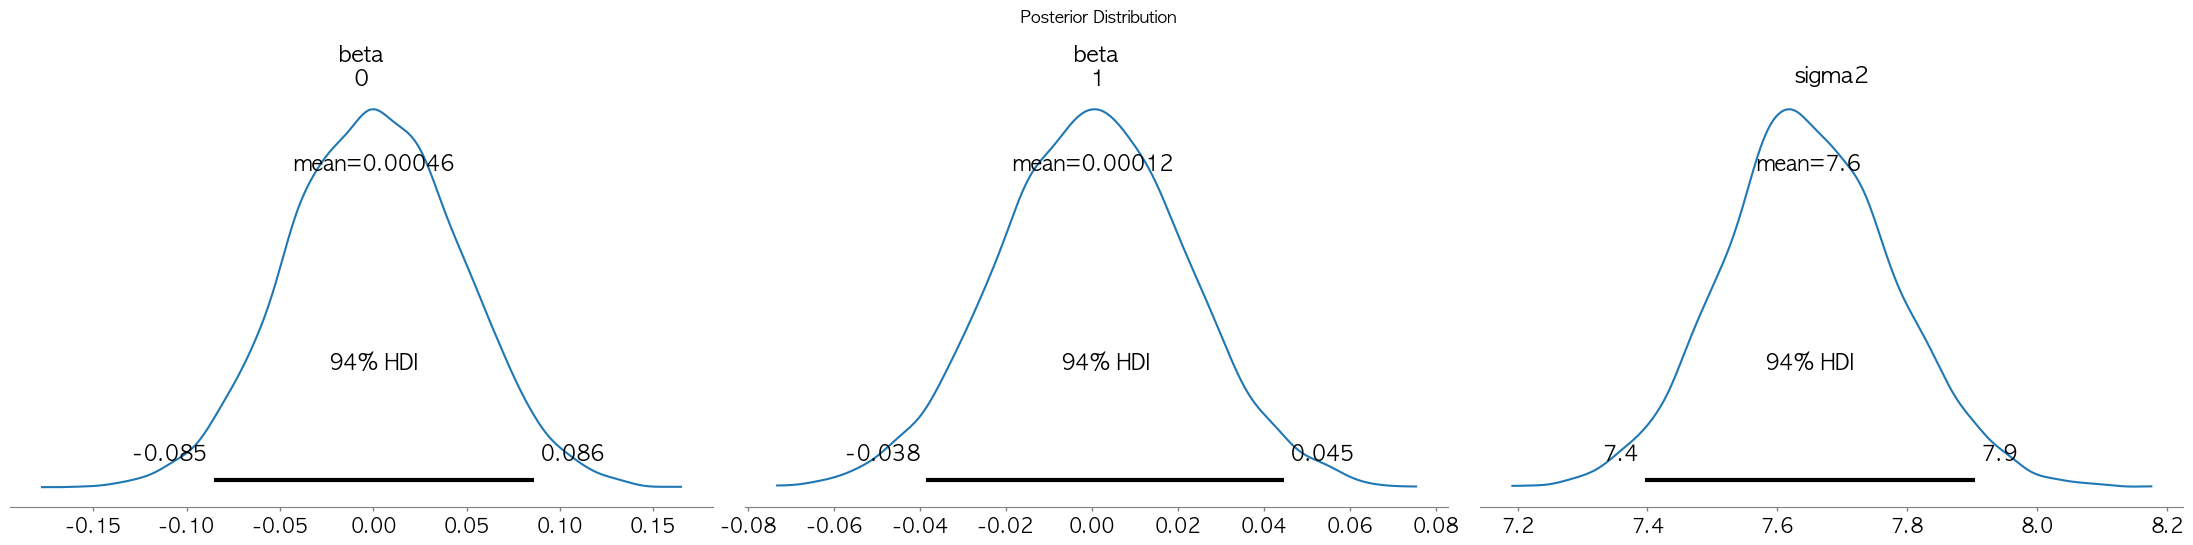

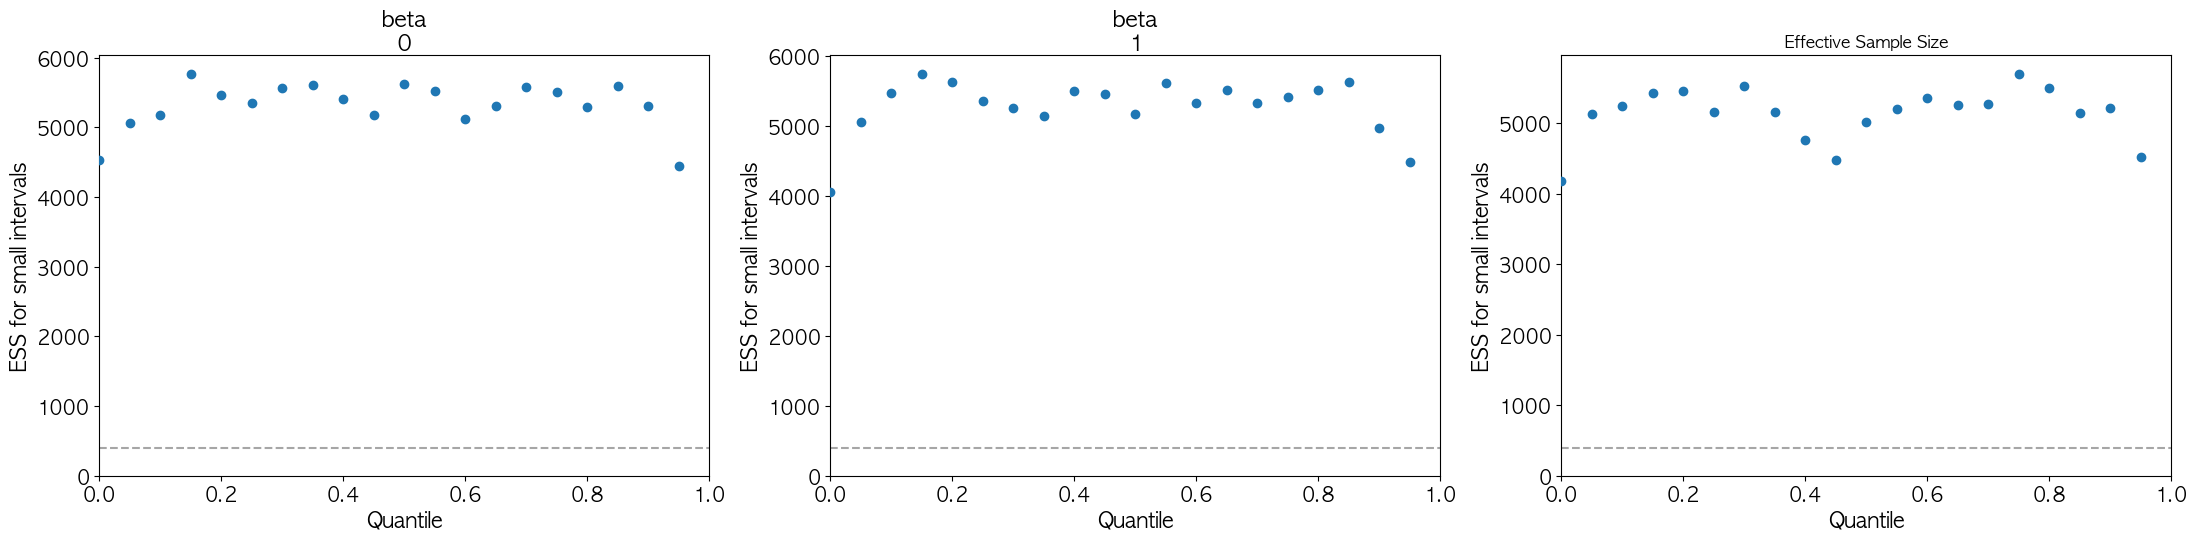

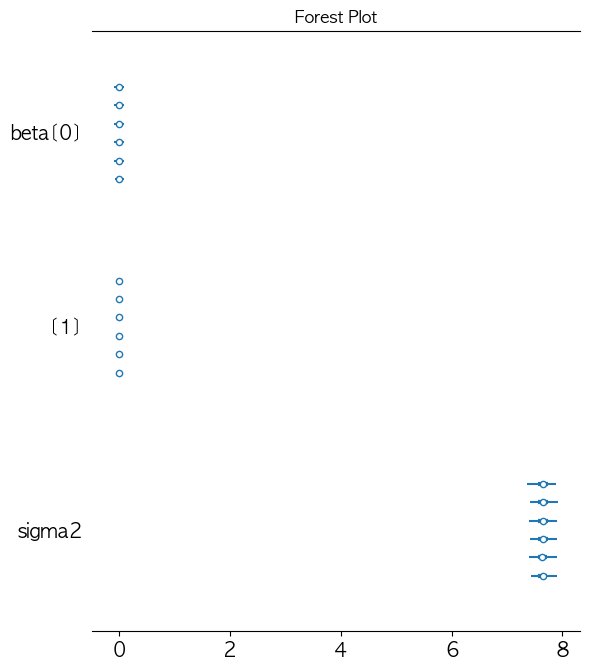

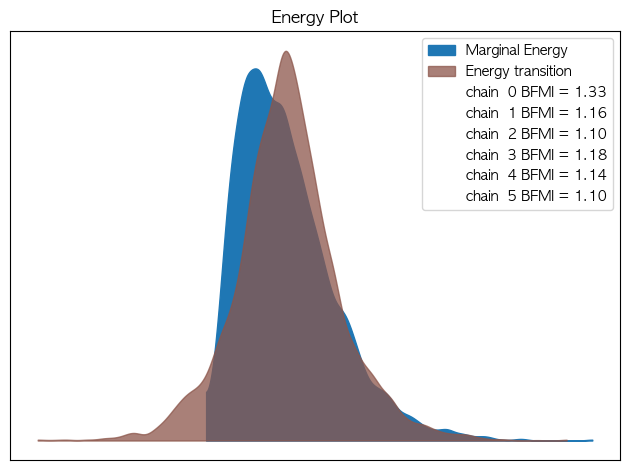

Summary Statistics:
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]  0.000  0.046  -0.085    0.086      0.001    0.001    3900.0   
beta[1]  0.000  0.022  -0.038    0.045      0.000    0.000    3916.0   
sigma2   7.648  0.135   7.396    7.904      0.002    0.001    4247.0   

         ess_tail  r_hat  
beta[0]    4450.0    1.0  
beta[1]    4050.0    1.0  
sigma2     4187.0    1.0  


In [49]:
# 데일리 데이터에 대한 회귀 분석 실행
trace = run_bayesian_regression(exchange_rate_change_daily, interest_rate_diff_daily)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [sigma2, beta]


Output()

Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 23 seconds.


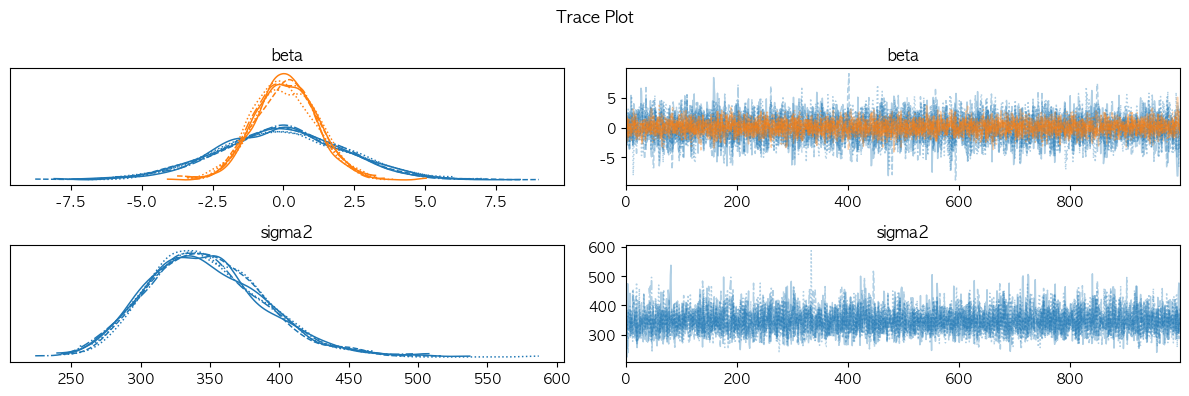

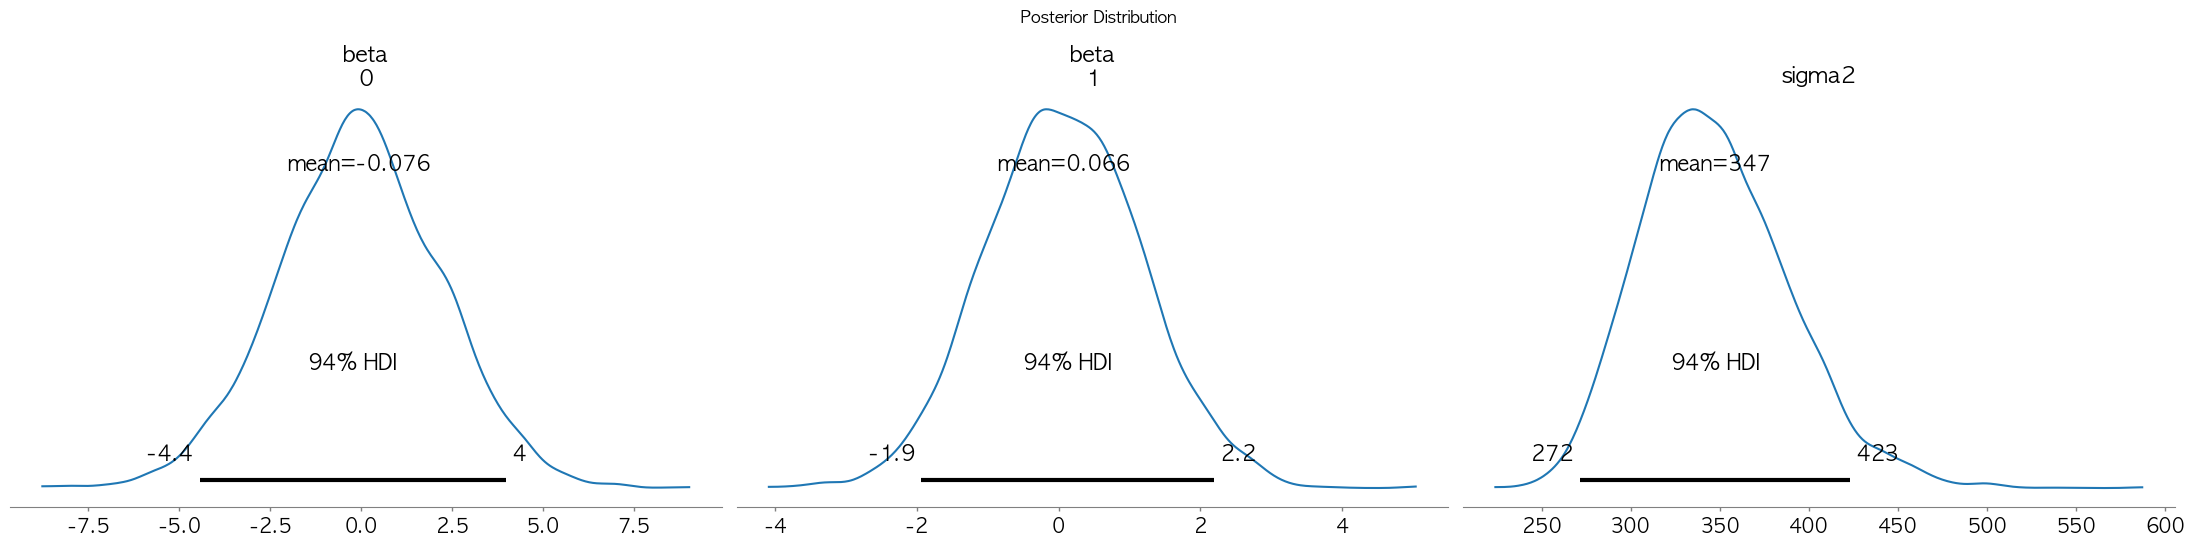

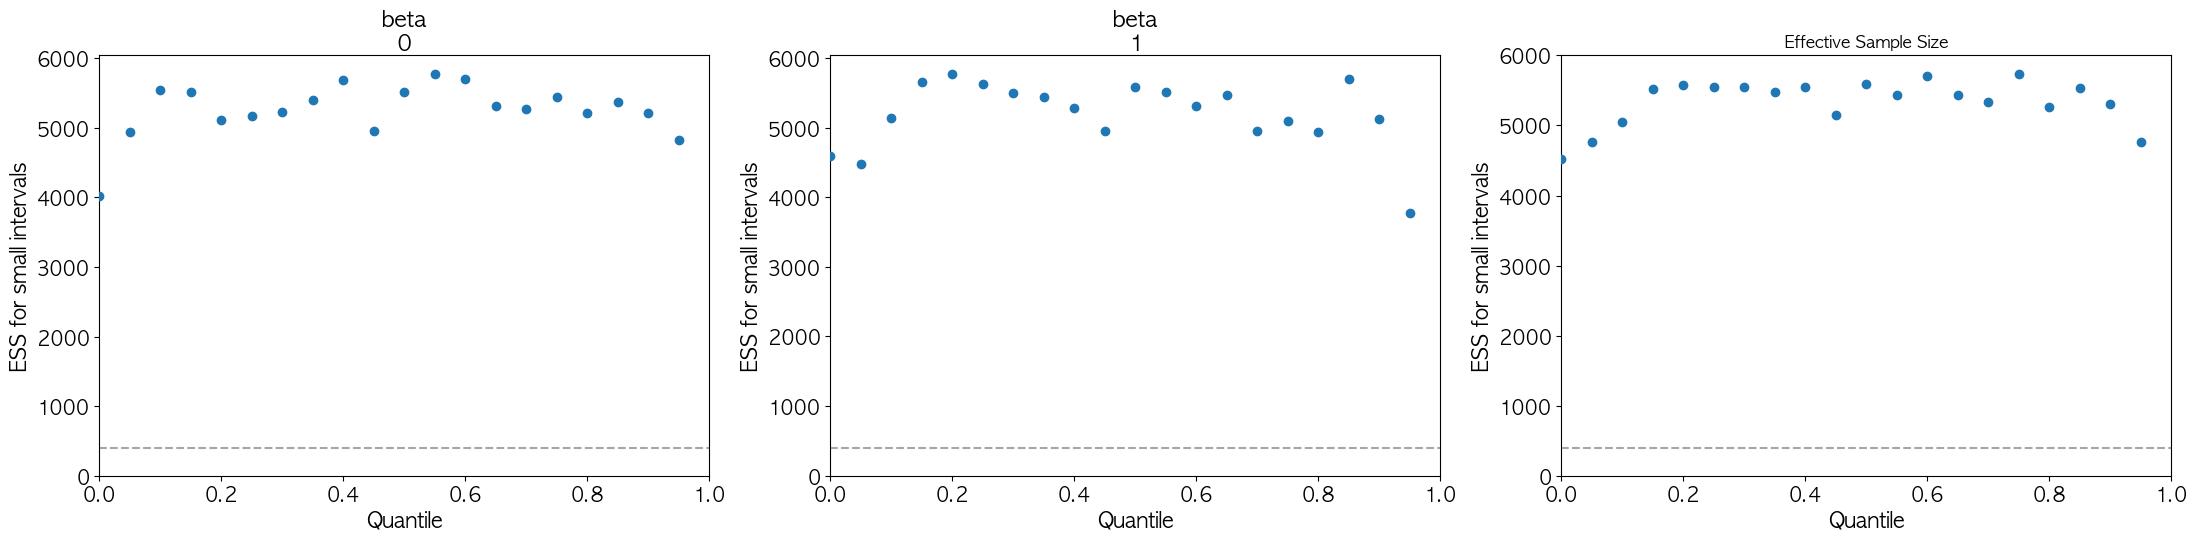

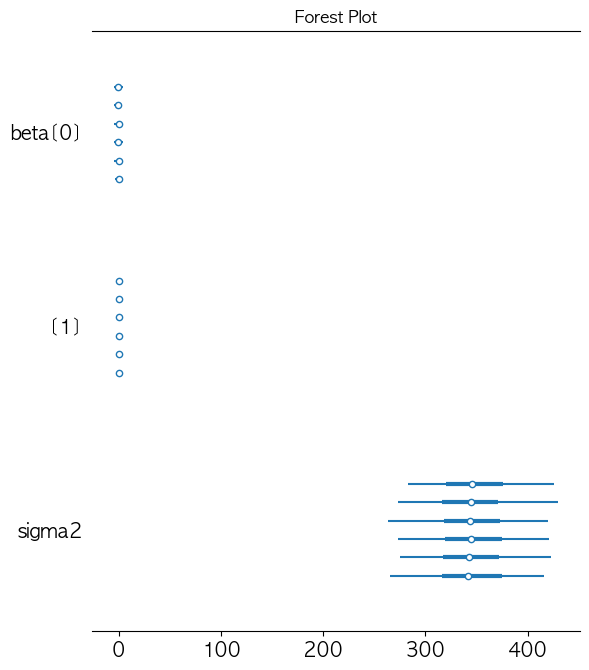

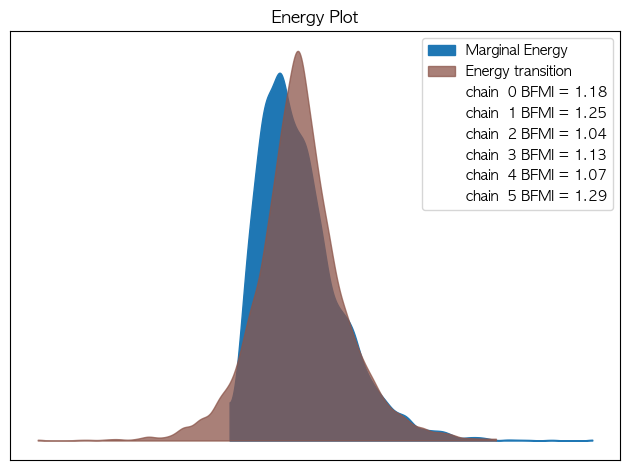

Summary Statistics:
            mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]   -0.076   2.241   -4.44    3.984      0.039    0.027    3362.0   
beta[1]    0.066   1.105   -1.94    2.195      0.020    0.014    3179.0   
sigma2   347.343  41.734  271.52  423.290      0.553    0.396    5801.0   

         ess_tail  r_hat  
beta[0]    4025.0    1.0  
beta[1]    3774.0    1.0  
sigma2     4516.0    1.0  


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [51]:

# 쿼터리 데이터에 대한 회귀 분석 실행
run_bayesian_regression(exchange_rate_change_quarterly, interest_rate_diff_quarterly)